In [40]:
import time
import copy
import numpy
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [41]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [42]:
dataset = torchvision.datasets.ImageFolder('/Users/gnbhavithran/Python_github/My_storage_to_remind/Python_Programs_On_CNN/tiny-imagenet-200/train', transform=transform)

In [43]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [80000, 10000, 10000])

In [44]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

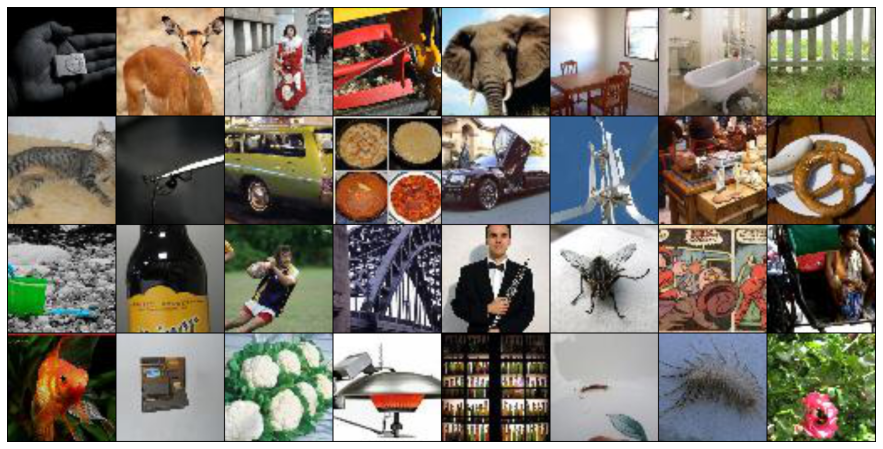

In [45]:
from torchvision.utils import make_grid

for images, _ in training_data:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [46]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):   #kwargs is keyword arguments when 
        # its given take the value is the meaning
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [47]:
class InceptionBlock(nn.Module):
    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()

        self.one_by_one         = ConvBlock(im_channels, num_1x1, kernel_size = 1)

        self.three_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size = 1)
        self.three_by_three     = ConvBlock(num_3x3_red, num_3x3, kernel_size = 3, padding = 1)

        self.five_by_five_red   = ConvBlock(im_channels, num_5x5_red, kernel_size = 1)
        self.five_by_five       = ConvBlock(num_5x5_red, num_5x5, kernel_size = 5, padding = 2)

        self.maxpool            = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj          = ConvBlock(im_channels, num_pool_proj, kernel_size=1)

    def forward(self, x):
        x1  = self.one_by_one(x)

        x3  = self.three_by_three_red(x)
        x3  = self.three_by_three(x3)

        x5  = self.five_by_five_red(x)
        x5  = self.five_by_five(x5)

        p_p = self.maxpool(x)
        p_p = self.pool_proj(p_p)

        x   = torch.cat([x1, x3, x5, p_p], 1)
        return x




In [48]:
class Auxiliary(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [70]:
class Inception(nn.Module):
    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=1000):
        super(Inception, self).__init__()

        self.conv1   = ConvBlock(in_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.conv2   = ConvBlock(64, 192, kernel_size = 3, padding = 1)

        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.averpool= nn.AvgPool2d(kernel_size = 7)

        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)

        self.dropout = nn.Dropout(0.4)
        self.linear  = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(num_classes)
        self.inception_3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception_4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception_5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool(x)

        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self. maxpool(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.averpool(x)

        x = self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        # x = self.softmax(x)

        return x

In [71]:
model = Inception()

In [72]:
#define everything we need for training
epochs = 1 #50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [73]:
#define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [74]:
#move the model to the device
model.to(device)
next(model.parameters()).is_cuda

False

In [75]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):
    
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    if phase == 'train': # Backward + optimize only if in training phase
                        if use_auxiliary:
                            outputs, aux1, aux2 = model(inputs)
                            loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                        else:
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            
                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()
                    
                    if phase == 'val':
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [76]:
model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)

Epoch 0/0
----------


ValueError: too many values to unpack (expected 3)